# Word2vec

### 1. 추론 기반 기법과 신경망
단어를 벡터로 변환 하는 것에 가장 성공적인 두 부류는 '통계 기반 기법'과 '추론 기반 기법' 두가지이며 그 배경은 모두 분포 가설임

#### 통계 기반 기법의 문제점
동시발생 행렬을 만들고 SVD를 적용하여 밀집벡터를 얻는 것은 여러 문제를 야기함
- 현업에서 다루는 말뭉치의 어휘 수는 어마어마함 (ex. 영어의 어휘 수는 100만 이상, 100만x100만 행렬은 비현실적)
- 미니배치 학습이 어려움

#### 추론 기반 기법 개요
주변단어(맥락)이 주어졌을 때 무슨 단어가 들어 갈지를 추측하는 작업으로 단어의 출현 패턴을 학습, 학습의 결과로 분산 표현을 얻는 것이 추론 기반 기법의 전체 그림

#### 신경망에서의 단어 처리
가장 대표적인 방법은 원핫 벡터

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])    # 입력
W = np.random.randn(7, 3)    # 가중치
h = np.matmul(c, W)          # 중간 노드
print(h)

[[ 1.059882    0.00178589 -0.25277976]]


### 2. 단순한 word2vec
word2vec 에서 제안하는 CBOW(Continuous bag-of-words)

#### CBOW 모델의 추론처리
CBOW 모델은 맥락으로부터 타깃을 추측하는 용도의 신경망 모델임

In [3]:
import numpy as np

# 심플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 순전파
h0 = np.matmul(c0, W_in)
h1 = np.matmul(c1, W_in)
h = 0.5 * (h0 + h1)    # 두 입력에 평균값
s = np.matmul(h, W_out)

print(s)

[[ 1.47358699 -2.55565681  0.42242861 -1.22542524  1.53364928 -0.19448394
   0.58746165]]


#### CBOW 모델의 학습
CBOW모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조절하는 일을 함

#### word2vec의 가중치와 분산 표현
word2vec에서 사용되는 신경망에는 두 가지 가중치가 있음. 완전연결계층의 가중치(W_in)과 완전출력층계층의 가중치(W_out)   
W_in의 각 행에는 각 단어의 분산 표현에 해당, W_out은 인코딩된 벡터가 저장   
단어 쪽 분산 표현으로 어느 쪽 가중치를 선택하는 지는 다음과 같음
- 입력층 가중치만 이용
- 출력층 가중치만 이용
- 양쪽 가중치 모두 이용
    
word2vec(특히, skip-gram모델)에서는 '입력 가중치만 이용'이 가장 보편적. 많은 연구에서 입력층 가중치만을 최종 단어에 분산으로 사용 

### 3. 학습 데이터 준비
("you say goodbye and I say hello"를 예시로 사용)

#### 맥락과 타깃
신경망에 '맥락'을 입력 했을 때 '타깃'이 출현할 확률을 높이는 것이 목표

In [4]:
# 전처리 함수
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word2id = {}
    id2word = {}
    for word in words:
        if word not in word2id:
            new_id = len(word2id)
            word2id[word] = new_id
            id2word[new_id] = word
            
    corpus = [word2id[w] for w in words]
    
    return corpus, word2id, id2word

text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)

print(corpus)
print(id2word)

[0, 1, 2, 3, 4, 1, 5, 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [5]:
# 맥락과 타깃을 만들어 주는 함수
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    context = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx+t])
        context.append(cs)
        
    return np.array(context), np.array(target)

context, target = create_contexts_target(corpus, window_size=1)

print(context)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


#### 원핫 표현으로 변환
맥락과 타깃을 원핫 벡터로 변경

In [6]:
# 원핫 벡터로 변환해주는 함수
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)

contexts, target = creat_context_target(corpus, window_size=1)

vocab_size = len(word2id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


### 4. CBOW모델 구현

In [23]:
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss
    
# CBOW 모델
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모음
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

#### 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

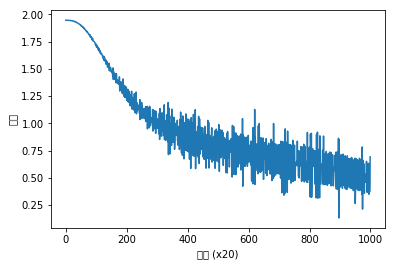

In [24]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word2id, id2word = preprocess(text)

vocab_size = len(word2id)
contexts, target = create_contexts_target(corpus, window_size=1)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [25]:
word_vecs = model.word_vecs
for word_id, word in id2word.items():
    print(word, word_vecs[word_id])

you [0.965313   0.94259274 1.7250036  0.9645215  0.95367885]
say [-1.1165712 -0.9302027  1.285966  -1.1431422 -1.1274965]
goodbye [ 0.9760851   1.0248897  -0.6955859   0.99009866  0.97666454]
and [-0.79296464 -1.7191837   1.2700883  -0.8920755  -0.44530368]
i [ 0.991834   1.050422  -0.6889756  0.9859735  1.0117621]
hello [0.97985023 0.9659199  1.7132168  0.9472816  0.95656884]
. [-1.1789757   0.69521224  0.9145486  -1.1110718  -1.4405829 ]
